In [ ]:
# If you have already installed from requirements.txt, this will just be a no-op.
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers==4.46.3 tokenizers==0.20.3 pillow numpy einops easydict addict img2pdf pymupdf

import os
import torch
from transformers import AutoModel, AutoTokenizer
from pathlib import Path
import requests
from IPython.display import Markdown, Image, display

MODEL_NAME = "deepseek-ai/DeepSeek-OCR"

print("Loading tokenizer and model:", MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

model = AutoModel.from_pretrained(
    MODEL_NAME,
    _attn_implementation="eager",   # avoids flash-attn / CUDA toolkit issues
    trust_remote_code=True,
    use_safetensors=True,
)

if torch.cuda.is_available():
    print("Using GPU")
    model = model.cuda().to(torch.bfloat16)
else:
    print("Using CPU (may be slower)")
    model = model.to(torch.bfloat16)

model = model.eval()

# --------------------------------------------------
# Paths + download the example page into data/
# --------------------------------------------------
project_root = Path(".").resolve()

data_dir = project_root / "data"
data_dir.mkdir(exist_ok=True)

output_dir = project_root / "outputs"
output_dir.mkdir(exist_ok=True)

# Download the image from GitHub into data/ if not present
img_url = "https://raw.githubusercontent.com/SudamshuRao/ANC_Extra_Credit_Team_11/main/data/gillanderscastro-NAEYC-pages.jpg"
img_path = data_dir / "gillanderscastro-NAEYC-pages.jpg"

if not img_path.exists():
    print("Downloading image from GitHub...")
    resp = requests.get(img_url)
    resp.raise_for_status()
    img_path.write_bytes(resp.content)
    print("Saved image as:", img_path)
else:
    print("Image already exists at:", img_path)

# Use the single downloaded image
image_files = [img_path]

print(f"Found {len(image_files)} images in {data_dir}")

assert len(image_files) > 0, f"No images found in {data_dir}. Please add at least one image."

# --------------------------------------------------
# 1) Pass 1 – Convert document to Markdown (original behavior)
# --------------------------------------------------
prompt_md = "<image>\n<|grounding|>Convert the document to markdown."

for img in image_files:
    print(f"\n[Markdown pass] Processing: {img.name}")
    res = model.infer(
        tokenizer,
        prompt=prompt_md,
        image_file=str(img),
        output_path=str(output_dir),
        base_size=1024,
        image_size=640,
        crop_mode=True,
        save_results=True,
        test_compress=True,
    )

print("\nAll images processed for Markdown.")
print("Results saved in:", output_dir)

# Show the latest markdown result in a nice box
md_files = sorted(list(output_dir.glob("*.mmd")) + list(output_dir.glob("*.md")))
if not md_files:
    print("No markdown (.mmd/.md) files found in outputs/")
else:
    md_file = md_files[-1]  # take the newest
    print("Rendering markdown file:", md_file.name)
    md_text = md_file.read_text(encoding="utf-8")

    # Fix image paths if needed (DeepSeek usually saves images/ under outputs/)
    md_text = md_text.replace("](images/", "](outputs/images/")

    display(Markdown(md_text))

# --------------------------------------------------
# 2) Pass 2 – Ask DeepSeek-OCR for bounding boxes
#    (this is what should trigger result_with_boxes.jpg)
# --------------------------------------------------
prompt_boxes = "<image>\n<|grounding|>Identify all objects in the image and output them in bounding boxes."

for img in image_files:
    print(f"\n[Bounding-box pass] Processing: {img.name}")
    res_boxes = model.infer(
        tokenizer,
        prompt=prompt_boxes,
        image_file=str(img),
        output_path=str(output_dir),
        base_size=1024,
        image_size=640,
        crop_mode=True,
        save_results=True,
        test_compress=True,
    )

print("\nBounding-box pass finished.")
print("Results (including any overlay image) saved in:", output_dir)

# Show the boxed image if DeepSeek generated it
boxed_path = output_dir / "result_with_boxes.jpg"



Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 110.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2
Loading tokenizer and model: deepseek-ai/DeepSeek-OCR


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

conversation.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- configuration_deepseek_v2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- modeling_deepseekv2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


deepencoder.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- deepencoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- modeling_deepseekocr.py
- conversation.py
- configuration_deepseek_v2.py
- modeling_deepseekv2.py
- deepencoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using GPU
Saved image as: /content/data/gillanderscastro-NAEYC-pages.jpg
Found 1 images in /content/data

[Markdown pass] Processing: gillanderscastro-NAEYC-pages.jpg


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Cal

BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>title<|/ref|><|det|>[[123, 104, 342, 305]]<|/det|>
# Storybook Reading for Young Dual Language Learners  

<|ref|>text<|/ref|><|det|>[[153, 348, 315, 380]]<|/det|>
Cristina Gillanders and Dina C. Castro  

<|ref|>image<|/ref|><|det|>[[368, 65, 978, 401]]<|/det|>  

<|ref|>text<|/ref|><|det|>[[93, 412, 368, 456]]<|/det|>
In a community of practice meeting, teachers discuss their experiences reading aloud to dual language learners.  

<|ref|>text<|/ref|><|det|>[[93, 463, 370, 520]]<|/det|>
Susan: When I am reading a story, the Latino children in my class just sit there. They look at me, but you can tell that they are not engaged in the story.  

<|ref|>text<|/ref|><|det|>[[93, 526, 349, 568]]<|/det|>
Lisa: That happens in my class too. The little girls play with their hair, and the boys play with their shoes.  

<|ref|>text<|/ref|><|det|>[[93, 575, 350, 631]]<|/det|>
Beverly: And when you ask questions about th

other: 100%|██████████| 17/17 [00:00<00:00, 84183.20it/s]


All images processed for Markdown.
Results saved in: /content/outputs
Rendering markdown file: result.mmd



# Storybook Reading for Young Dual Language Learners  


Cristina Gillanders and Dina C. Castro  

![](outputs/images/0.jpg)
  


In a community of practice meeting, teachers discuss their experiences reading aloud to dual language learners.  


Susan: When I am reading a story, the Latino children in my class just sit there. They look at me, but you can tell that they are not engaged in the story.  


Lisa: That happens in my class too. The little girls play with their hair, and the boys play with their shoes.  


Beverly: And when you ask questions about the story, children who speak English take over and you can't get an answer from the Latino children.  


Facilitator: What do you think is happening here?  


Lisa: I think they just don't understand what the story is about.  


Facilitator: How can we help them understand the story so they can participate?  


RESEARCHERS WIDELY RECOMMEND storybook reading for promoting the early language and literacy of young children. By listening to stories, children learn about written syntax and vocabulary and develop phonological awareness and concepts of print, all of which are closely linked to learning to read and write (National Early Literacy Panel 2008). Teachers usually know a read- aloud experience has been effective because they see the children maintain their interest in the story, relate different aspects of the story to their own experiences, describe the illustrations, and ask questions about the characters and plot.  


However, listening to a story read aloud can be a very different experience for children who speak a language other than English. What  


Cristina Gillanders, PhD, is a researcher at the FPG Child Development Institute at the University of North Carolina- Chapel Hill. She was an investigator in the Nuestros Ninos study, and has worked with dual language learners as a bilingual preschool teacher, teacher educator, and researcher. cristina.gillanders@unc.edu  


Dina C. Castro, PhD, is a senior scientist at the FPG Child Development Institute. She was one of two principal investigators for the Nuestros Ninos study. Her research focuses on improving the quality of early education for children from diverse cultural and linguistic backgrounds. dina.castro@unc.edu  


Photos courtesy of the authors.  


A study guide for this article will be available in mid- January online at www.naeyc.org/yc.  


happens when the children are read to in a language they are just beginning to learn? What happens when an English- speaking teacher reads a story to a group of children who are learning English as a second language?  


As illustrated in the vignette at the beginning of this article, teachers often describe young dual language learners in their class as distracted and unengaged during read- aloud sessions in English. In this article, we describe teaching strategies that English- speaking teachers can use when reading aloud to young dual language learners. These strategies are part of the Nuestros Ninos Early Language and Literacy Program, a professional development intervention designed to improve the quality of teaching practices in prekindergarten classrooms to support Spanish- speaking dual language learners (Castro et al. 2006). The intervention was developed and evaluated in a study funded by the US Department of Education. Teachers from the North Carolina More at Four Pre- Kindergarten


[Bounding-box pass] Processing: gillanderscastro-NAEYC-pages.jpg


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>title<|/ref|><|det|>[[123, 105, 343, 305]]<|/det|>
Storybook Reading for Young Dual Language Learners  

<|ref|>text<|/ref|><|det|>[[153, 348, 314, 380]]<|/det|>
Cristina Gillanders and Dina C. Castro  

<|ref|>image<|/ref|><|det|>[[368, 65, 978, 400]]<|/det|>  

<|ref|>text<|/ref|><|det|>[[93, 412, 366, 456]]<|/det|>
In a community of practice meeting, teachers discuss their experiences reading aloud to dual language learners.  

<|ref|>text<|/ref|><|det|>[[93, 463, 370, 520]]<|/det|>
Susan: When I am reading a story, the Latino children in my class just sit there. They look at me, but you can tell that they are not engaged in the story.  

<|ref|>text<|/ref|><|det|>[[93, 526, 350, 568]]<|/det|>
Lisa: That happens in my class too. The little girls play with their hair, and the boys play with their shoes.  

<|ref|>text<|/ref|><|det|>[[93, 575, 350, 631]]<|/det|>
Beverly: And when you ask questions about the 

other: 100%|██████████| 17/17 [00:00<00:00, 112288.45it/s]


Bounding-box pass finished.
Results (including any overlay image) saved in: /content/outputs


Displaying: /content/outputs/result_with_boxes.jpg


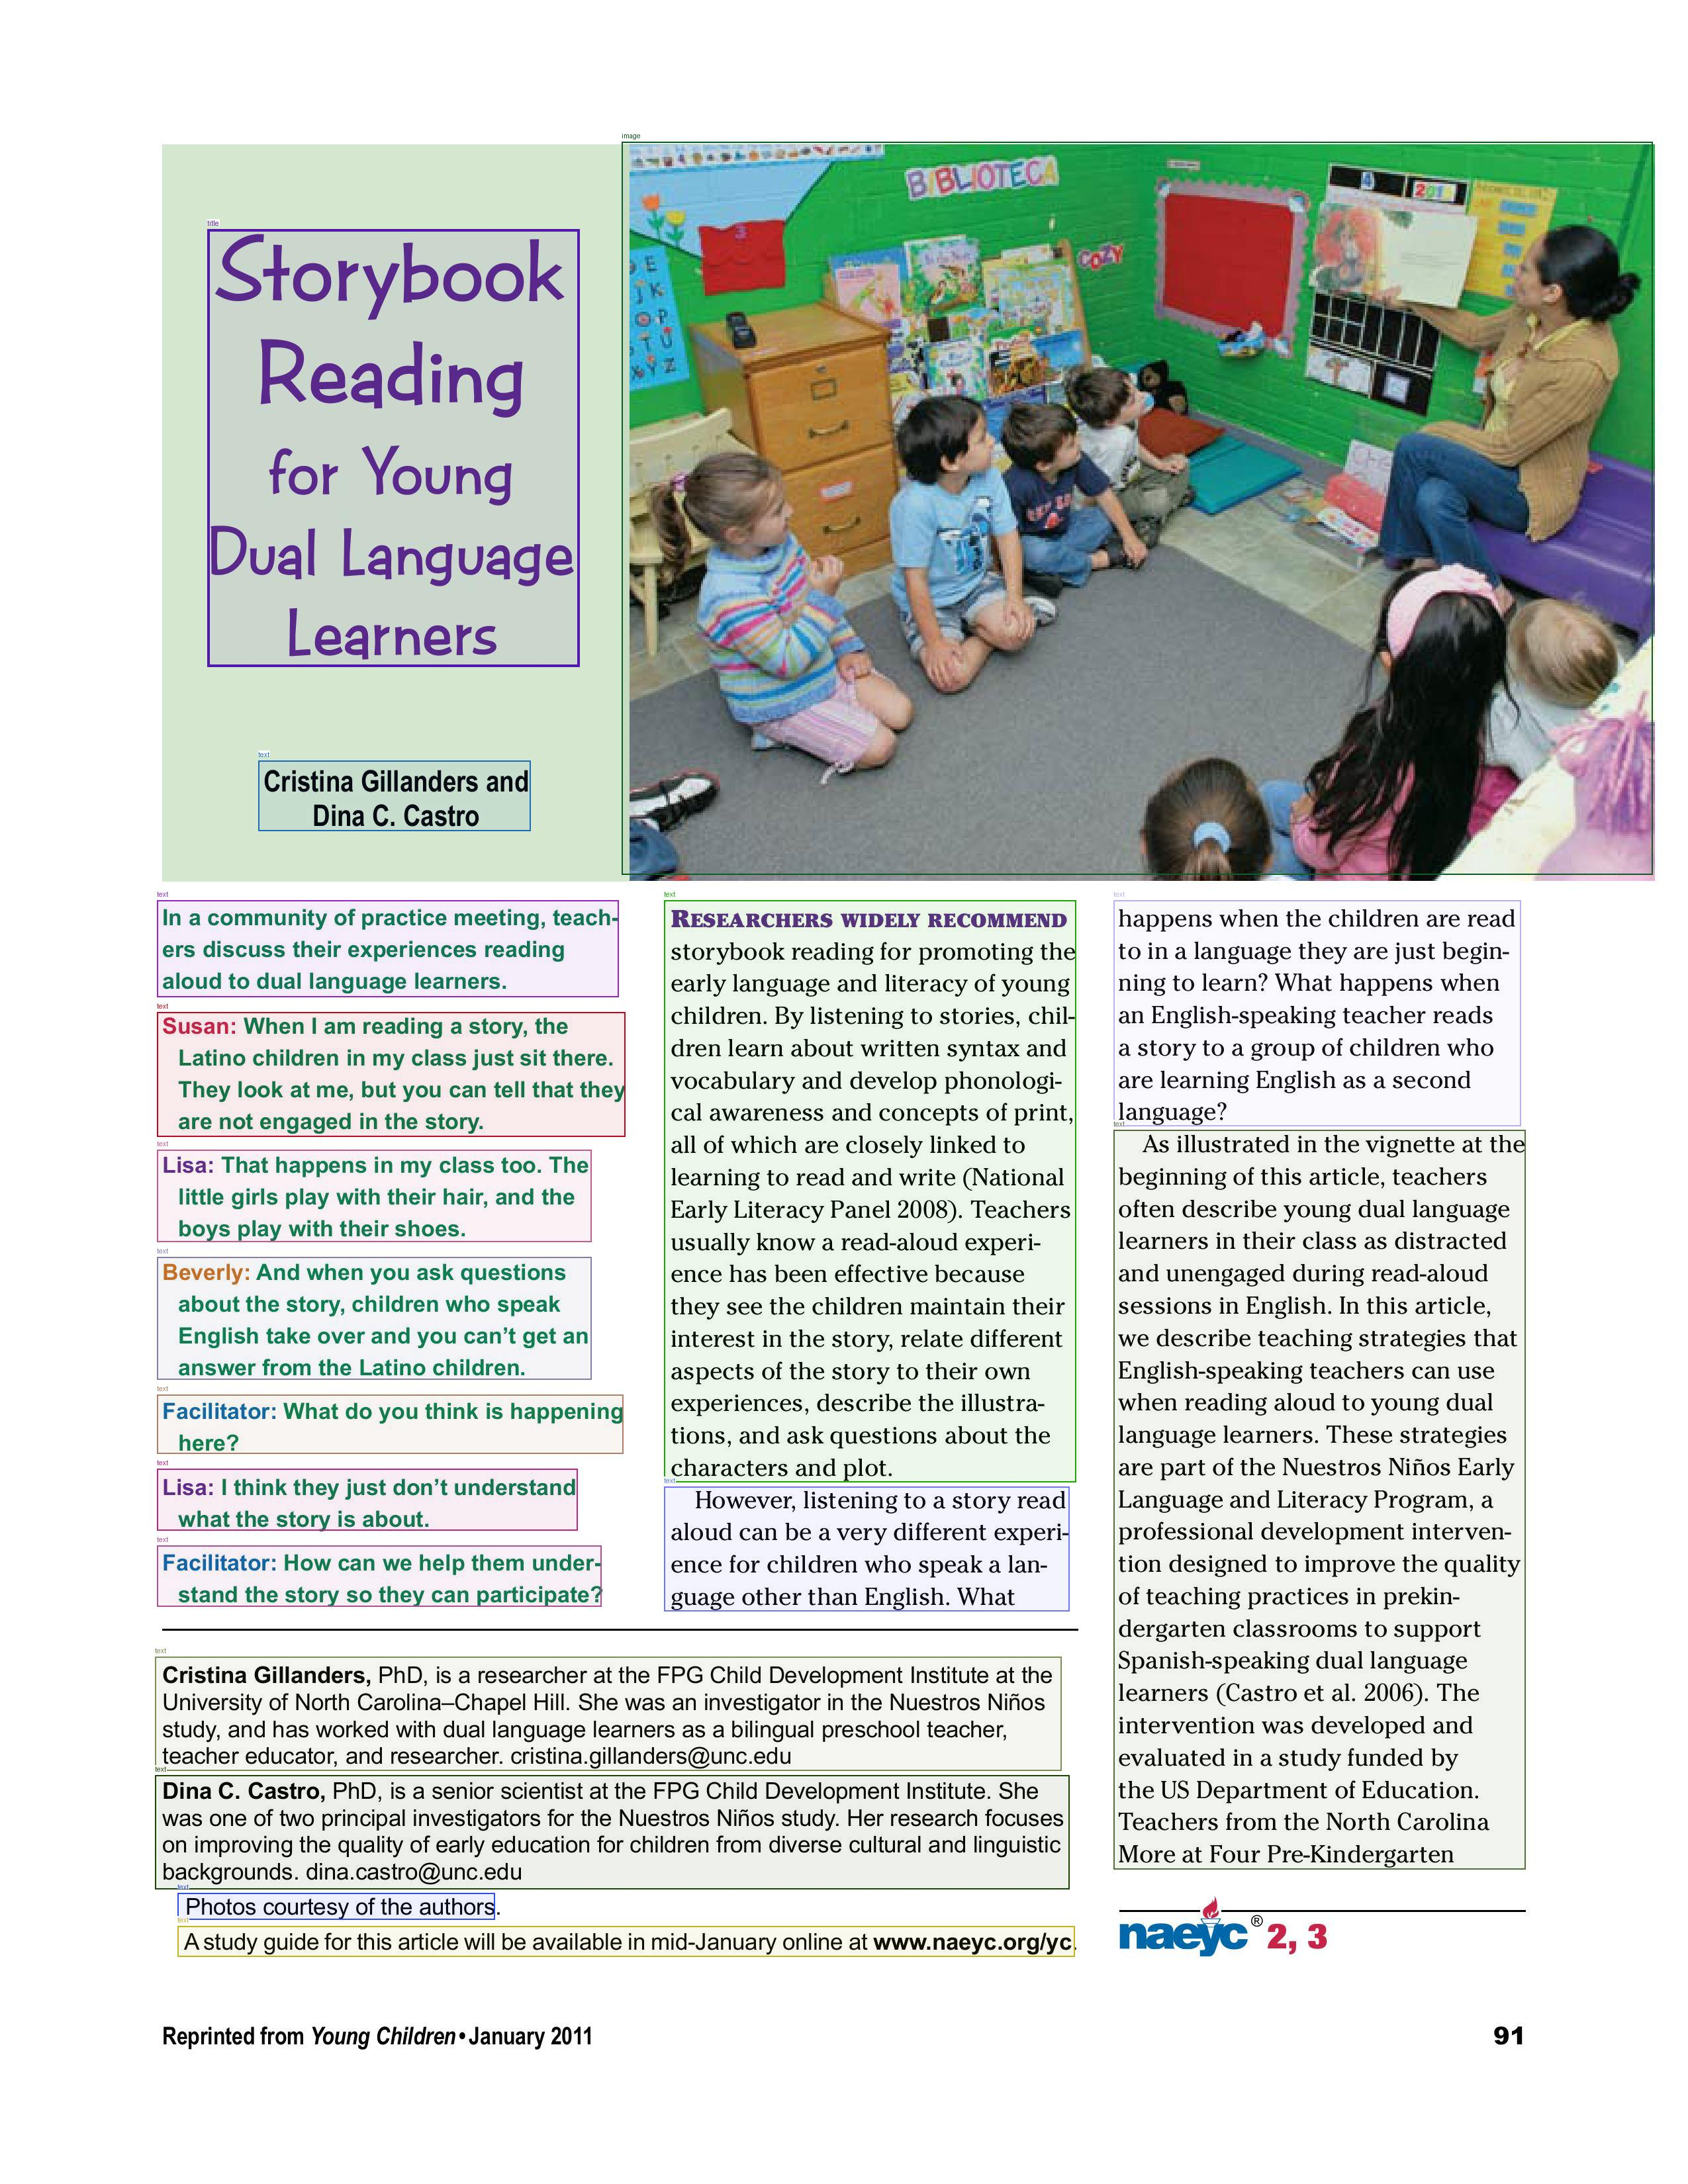

In [ ]:
if boxed_path.exists():
    print("Displaying:", boxed_path)
    display(Image(filename=str(boxed_path)))
else:
    print("result_with_boxes.jpg not found in outputs/ – "
          "this likely means the model did not produce a boxed overlay for this prompt.")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Page size: 2550 3300
Saved cropped figure as: /content/outputs/deep_parsing_figure.jpg
directly resize
BASE:  torch.Size([1, 100, 1280])
NO PATCHES
The image depicts an indoor classroom setting with a group of children and an adult. The children are seated on the floor, facing towards the right side of the frame where an adult, presumably a teacher, is standing. The children are wearing casual clothing, and their attention is directed towards the teacher, suggesting an interactive learning environment.

The classroom is decorated with educational materials. On the left wall, there is a colorful alphabet chart with letters and corresponding images. Above the alphabet chart, there are several posters with various educational content. The wall is painted in a bright green color, which is typical for a classroom to create a cheerful atmosphere.

The floor is covered with a gray carpet, and there are several cushions and a small table visible in the scene. The cushions are in shades of blue

image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]

Using parsing text from: result.mmd


Saved Deep Parsing card v5 to: /content/outputs/deep_parsing_card_v5.jpg


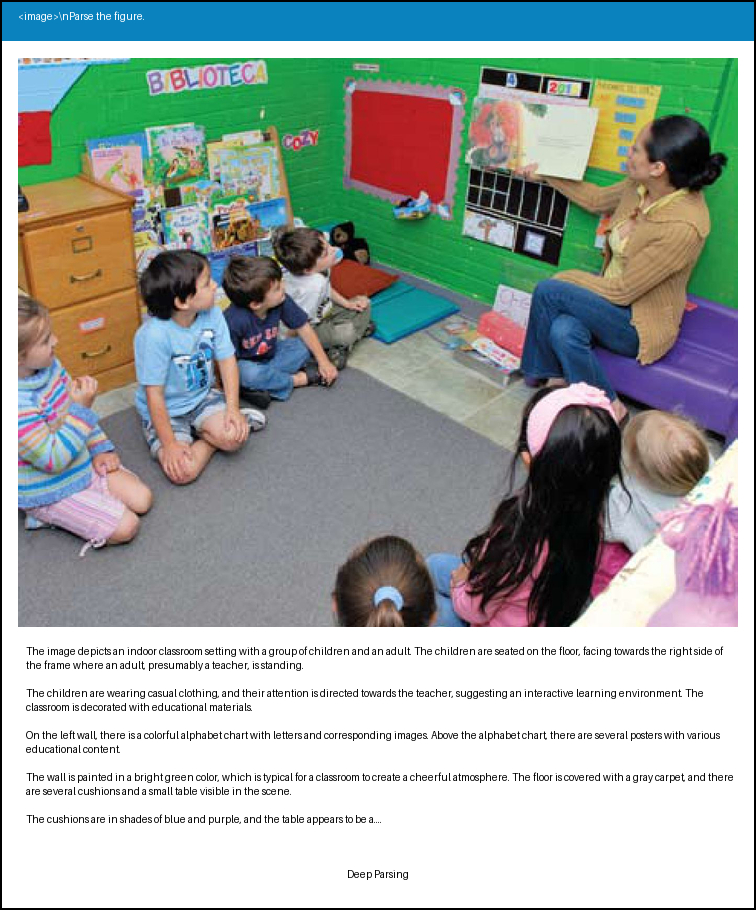

In [ ]:
# === Deep Parsing card – text width matches image width ===
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import os

project_root = Path(".").resolve()
data_dir = project_root / "data"
output_dir = project_root / "outputs"
output_dir.mkdir(exist_ok=True)

# 1) Load full page and crop ONLY the classroom photo
page_path = data_dir / "gillanderscastro-NAEYC-pages.jpg"
page_img = Image.open(page_path).convert("RGB")
W, H = page_img.size
print("Page size:", W, H)

crop_box = (
    int(W * 0.44),   # left
    int(H * 0.07),   # top
    int(W * 0.98),   # right
    int(H * 0.40),   # bottom
)
figure_img = page_img.crop(crop_box)

figure_path = output_dir / "deep_parsing_figure.jpg"
figure_img.save(figure_path)
print("Saved cropped figure as:", figure_path)

#display(figure_img)

# 2) Run DeepSeek-OCR parsing: "<image>\nParse the figure."
parse_prompt = "<image>\nParse the figure."

res = model.infer(
    tokenizer,
    prompt=parse_prompt,
    image_file=str(figure_path),
    output_path=str(output_dir),
    base_size=1024,
    image_size=640,
    crop_mode=False,
    save_results=True,
    test_compress=False,
)

mmd_candidates = list(output_dir.glob("*.mmd")) + list(output_dir.glob("*.md"))
if not mmd_candidates:
    raise RuntimeError("No .mmd/.md file found after parsing.")
parse_file = max(mmd_candidates, key=os.path.getmtime)
parse_text = parse_file.read_text(encoding="utf-8").strip()
print("Using parsing text from:", parse_file.name)

# ---- clean + slightly shorten text so font can be readable ----
parse_text = parse_text.replace("\n", " ")
MAX_CHARS = 900
if len(parse_text) > MAX_CHARS:
    parse_text = parse_text[:MAX_CHARS].rsplit(" ", 1)[0] + "…"

# split into pseudo-paragraphs (every ~2 sentences)
sentences = parse_text.split(". ")
paragraphs = []
para = []
for i, s in enumerate(sentences):
    if not s.endswith("."):
        s = s + "."
    para.append(s)
    if (i + 1) % 2 == 0:
        paragraphs.append(" ".join(para))
        para = []
if para:
    paragraphs.append(" ".join(para))

# ========================
# 3) Build the card image
# ========================
margin_outer = 18          # outer margin
header_h = 40
caption_h = 50
header_color = (10, 130, 190)  # teal-ish

# scale figure to a fixed max width
max_fig_w = 720
fig_w, fig_h = figure_img.size
scale = min(max_fig_w / fig_w, 1.0)
new_fig_w = int(fig_w * scale)
new_fig_h = int(fig_h * scale)
figure_scaled = figure_img.resize((new_fig_w, new_fig_h), Image.LANCZOS)

# card width is image width + margins (no extra blank on right)
card_w = new_fig_w + 2 * margin_outer

# fonts
try:
    font_body = ImageFont.truetype("DejaVuSans.ttf", 46)
    font_header = ImageFont.truetype("DejaVuSans.ttf", 28)
    font_caption = ImageFont.truetype("DejaVuSans.ttf", 46)
except OSError:
    font_body = ImageFont.load_default()
    font_header = ImageFont.load_default()
    font_caption = ImageFont.load_default()

# helper: wrap paragraphs by **pixel width**
def wrap_paragraphs_pixel(paragraphs, font, max_width_px, draw, indent_spaces=4):
    lines = []
    indent = " " * indent_spaces

    for p in paragraphs:
        words = p.split()
        if not words:
            continue

        # first line with indent
        current = indent + words[0]
        for w in words[1:]:
            candidate = current + " " + w
            if draw.textlength(candidate, font=font) <= max_width_px:
                current = candidate
            else:
                lines.append(current)
                current = indent + w  # new line, indent again

        lines.append(current)
        lines.append("")  # blank line between paragraphs

    if lines and lines[-1] == "":
        lines.pop()

    return "\n".join(lines)

# we want text to line up exactly under the image:
fig_x = margin_outer              # image left
text_x = fig_x                    # text starts under same x
max_text_width = new_fig_w        # text fills image width

# temporary draw context to measure text height
tmp_img = Image.new("RGB", (card_w, 2000), "white")
tmp_draw = ImageDraw.Draw(tmp_img)

body_text = wrap_paragraphs_pixel(paragraphs, font_body, max_text_width, tmp_draw)

bbox = tmp_draw.multiline_textbbox(
    (0, 0),
    body_text,
    font=font_body,
    spacing=4,
    align="left",
)
text_h = bbox[3] - bbox[1]

# total height
card_h = (
    header_h
    + margin_outer
    + new_fig_h
    + margin_outer
    + text_h
    + margin_outer
    + caption_h
    + margin_outer
)

card = Image.new("RGB", (card_w, card_h), "white")
draw = ImageDraw.Draw(card)

# header bar
draw.rectangle([0, 0, card_w, header_h], fill=header_color)
header_text = "<image>\\nParse the figure."
draw.multiline_text(
    (margin_outer, 10),
    header_text,
    fill="white",
    font=font_header,
    spacing=2,
    align="left",
)

# paste figure (aligned to left margin)
fig_y = header_h + margin_outer
card.paste(figure_scaled, (fig_x, fig_y))

# body text – same left as image, width == image width
text_y = fig_y + new_fig_h + margin_outer
draw.multiline_text(
    (text_x, text_y),
    body_text,
    fill="black",
    font=font_body,
    spacing=4,
    align="left",
)

# caption "Deep Parsing" centered at bottom
caption_text = "Deep Parsing"
caption_y = card_h - caption_h
caption_w = draw.textlength(caption_text, font=font_caption)
caption_x = (card_w - caption_w) // 2
draw.text((caption_x, caption_y + 8), caption_text, fill="black", font=font_caption)

# outer border
draw.rectangle([0, 0, card_w - 1, card_h - 1], outline="black", width=2)

# 4) Save and display
card_path = output_dir / "deep_parsing_card_v5.jpg"
card.save(card_path)
print("Saved Deep Parsing card v5 to:", card_path)

display(card)


In [ ]:
# 1. Install deps (torch is already there in Colab, so this is mostly a no-op)
!pip install transformers==4.46.3 tokenizers==0.20.3 pillow numpy einops easydict addict img2pdf pymupdf

import torch
from transformers import AutoModel, AutoTokenizer
from pathlib import Path
import requests
from IPython.display import Markdown, display

MODEL_NAME = "deepseek-ai/DeepSeek-OCR"

print("Loading tokenizer and model:", MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Let HF handle device placement (GPU if available); avoids manual .cuda() juggling
model = AutoModel.from_pretrained(
    MODEL_NAME,
    _attn_implementation="eager",   # avoids flash-attn / CUDA issues
    trust_remote_code=True,
    use_safetensors=True,
    torch_dtype=torch.bfloat16,     # try bfloat16 to save memory
    device_map="auto",              # will use GPU if available, else CPU
)

model = model.eval()

# -----------------------------
# 2. Download the image from GitHub into current directory
# -----------------------------
img_url = "https://raw.githubusercontent.com/SudamshuRao/ANC_Extra_Credit_Team_11/main/data/gillanderscastro-NAEYC-pages.jpg"
img_path = Path("gillanderscastro-NAEYC-pages.jpg")

print("Downloading image from GitHub...")
resp = requests.get(img_url)
resp.raise_for_status()
img_path.write_bytes(resp.content)
print("Saved image as:", img_path)

# -----------------------------
# 3. Run DeepSeek-OCR on that image
# -----------------------------
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

prompt = "<image>\n[grounding]Convert the document to markdown."

print(f"\nProcessing: {img_path.name}")
res = model.infer(
    tokenizer,
    prompt=prompt,
    image_file=str(img_path),
    output_path=str(output_dir),
    base_size=1024,
    image_size=640,
    crop_mode=True,
    save_results=True,
    test_compress=True,
)

print("\nDone. Results saved in:", output_dir)

# -----------------------------
# 4. Display the markdown result directly in Colab
# -----------------------------
md_files = sorted(output_dir.glob("*.md"))
if not md_files:
    print("No markdown files found in outputs/")
else:
    print("Rendering:", md_files[0].name)
    md_text = md_files[0].read_text(encoding="utf-8")
    display(Markdown(md_text))


Loading tokenizer and model: deepseek-ai/DeepSeek-OCR


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Saved image as: gillanderscastro-NAEYC-pages.jpg

Processing: gillanderscastro-NAEYC-pages.jpg


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
Storybook Reading for Young Dual Language Learners

Cristina Gillanders and Dina C. Castro

In a community of practice meeting, teachers discuss their experiences reading aloud to dual language learners.

Susan: When I am reading a story, the Latino children in my class just sit there. They look at me, but you can tell that they are not engaged in the story.

Lisa: That happens in my class too. The little girls play with their hair, and the boys play with their shoes.

Beverly: And when you ask questions about the story, children who speak English take over and you can't get an answer from the Latino children.

Facilitator: What do you think is happening here?

Lisa: I think they just don't understand what the story is about.

Facilitator: How can we help them understand the story so they can participate?

RESEARCHERS WIDELY RECOMMEND storybook reading for promoting the early language and literacy of young children.

image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


Done. Results saved in: outputs
No markdown files found in outputs/


In [ ]:
from IPython.display import Markdown, display

# Look for .mmd files instead of .md
mmd_files = sorted(output_dir.glob("*.mmd"))
if not mmd_files:
    print("No .mmd markdown files found in outputs/")
else:
    print("Rendering:", mmd_files[0].name)
    md_text = mmd_files[0].read_text(encoding="utf-8")
    display(Markdown(md_text))


Rendering: result.mmd


Storybook Reading for Young Dual Language Learners

Cristina Gillanders and Dina C. Castro

In a community of practice meeting, teachers discuss their experiences reading aloud to dual language learners.

Susan: When I am reading a story, the Latino children in my class just sit there. They look at me, but you can tell that they are not engaged in the story.

Lisa: That happens in my class too. The little girls play with their hair, and the boys play with their shoes.

Beverly: And when you ask questions about the story, children who speak English take over and you can't get an answer from the Latino children.

Facilitator: What do you think is happening here?

Lisa: I think they just don't understand what the story is about.

Facilitator: How can we help them understand the story so they can participate?

RESEARCHERS WIDELY RECOMMEND storybook reading for promoting the early language and literacy of young children. By listening to stories, children learn about written syntax and vocabulary and develop phonological awareness and concepts of print, all of which are closely linked to learning to read and write (National Early Literacy Panel 2008). Teachers usually know a read-aloud experience has been effective because they see the children maintain their interest in the story, relate different aspects of the story to their own experiences, describe the illustrations, and ask questions about the characters and plot.

However, listening to a story read aloud can be a very different experience for children who speak a language other than English. What happens when the children are read to in a language they are just beginning to learn? What happens when an English-speaking teacher reads a story to a group of children who are learning English as a second language?

As illustrated in the vignette at the beginning of this article, teachers often describe young dual language learners in their class as distracted and unengaged during read-aloud sessions in English. In this article, we describe teaching strategies that English-speaking teachers can use when reading aloud to young dual language learners. These strategies are part of the Nuestros Niños Early Language and Literacy Program, a professional development intervention designed to improve the quality of teaching practices in prekindergarten classrooms to support Spanish-speaking dual language learners (Castro et al. 2006). The intervention was developed and evaluated in a study funded by the US Department of Education. Teachers from the North Carolina More at Four Pre-Kindergarten